In [1]:
import matplotlib.pyplot as plt
import librosa
import torchaudio
import numpy as np
import torch
import torchyin
import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.init as init

In [2]:
eps = 1e-5
small = 0.1
a = torch.rand(3,4)-small
b = torch.clamp(a, min=eps)

In [14]:
single_note = "test-data/single-notes"

In [4]:
# waveform1, sample_rate = torchaudio.load(f"{single_note}/A0.wav")
# waveform2, sample_rate = torchaudio.load(f"{single_note}/A#0.wav")
# waveform3, sample_rate = torchaudio.load(f"{single_note}/B0.wav")
# cqt_spec1, times_spec1, freq_spec1 = spec.cqt_spec(waveform1, sample_rate, hop_length=256)
# cqt_spec2, times_spec2, freq_spec2 = spec.cqt_spec(waveform2, sample_rate, hop_length=256)
# cqt_spec3, times_spec3, freq_spec3 = spec.cqt_spec(waveform3, sample_rate, hop_length=256)

# # spec.vis_cqt_spectrogram(cqt_spec1, times_spec1, freq_spec1, 0, times_spec1[-1])
# # spec.vis_cqt_spectrogram(cqt_spec2, times_spec2, freq_spec2, 0, times_spec2[-1])
# # spec.vis_cqt_spectrogram(cqt_spec3, times_spec3, freq_spec3, 0, times_spec3[-1])

### Test creating W from single note audio file

In [15]:
W, freqs = init.init_W(single_note)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


### Test running MU iterations on a simple example from init W

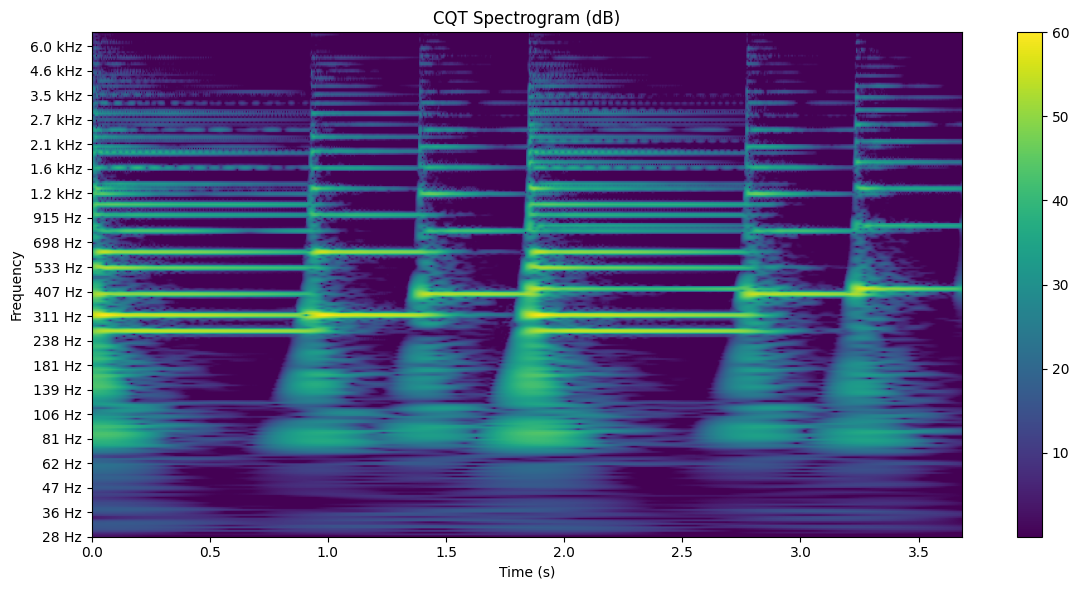

In [16]:
waveform_test, sample_rate_test = torchaudio.load("test-data/test-midi-transcription.wav")
cqt_test, times_test, freq_test = spec.cqt_spec(waveform_test, sample_rate_test, 256)

spec.vis_cqt_spectrogram(cqt_test, times_test, freq_test, 0, times_test[-1])
midi, times = spec.midi_to_pianoroll("test-data/test-midi-transcription.mid", waveform_test, times_test, hop_length=128)
onset, offset = utils.detect_onset_offset(midi)

In [17]:
f, t = cqt_test.shape
l = W.shape[1]
n_init_steps = 100

H = init.init_H(l, t, W, cqt_test, n_init_steps, beta=2)

### Test getting MIDI notes from W

In [18]:
pitches, notes, W, H = init.W_to_pitch(W, H, freqs)
print(notes, len(notes))

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87.]) 88


/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/init.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frequency = torch.tensor(frequency, dtype=torch.float32)


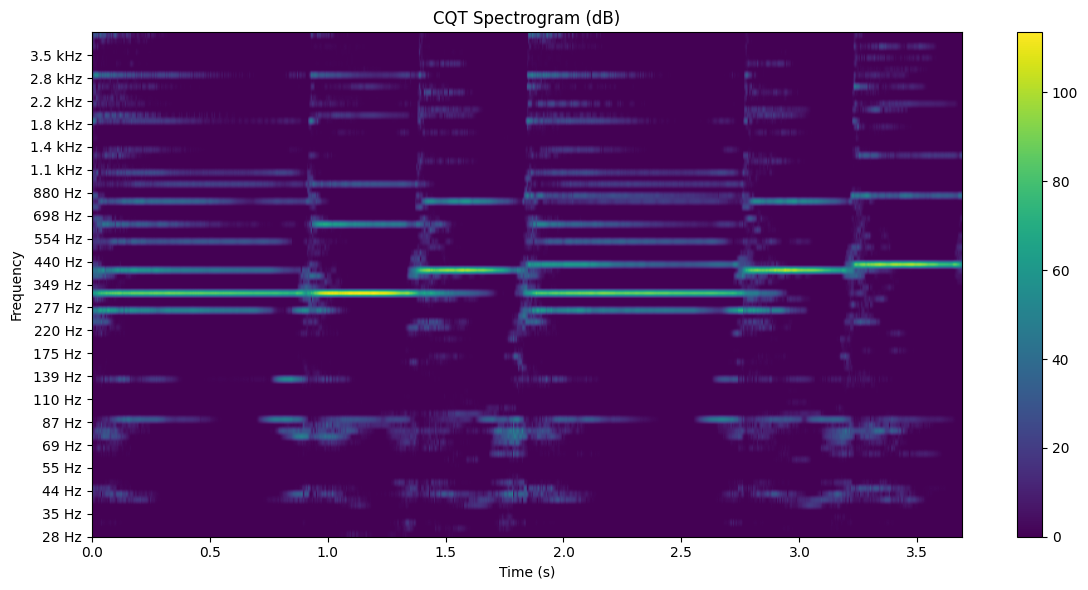

In [19]:
spec.vis_cqt_spectrogram(H, times_test, pitches, 0, 4)

### Test getting MIDI from H

In [45]:
midi_hat, active_midi = init.WH_to_MIDI(W, H, notes, threshold=0.02, smoothing_window=5, adaptative=False, normalize=True)
active_midi

[39, 42, 46, 47, 54]

In [32]:
active_midi = [i for i in range(88) if (midi[i,:]>0).any().item()]
active_midi

[39, 42, 46, 47]

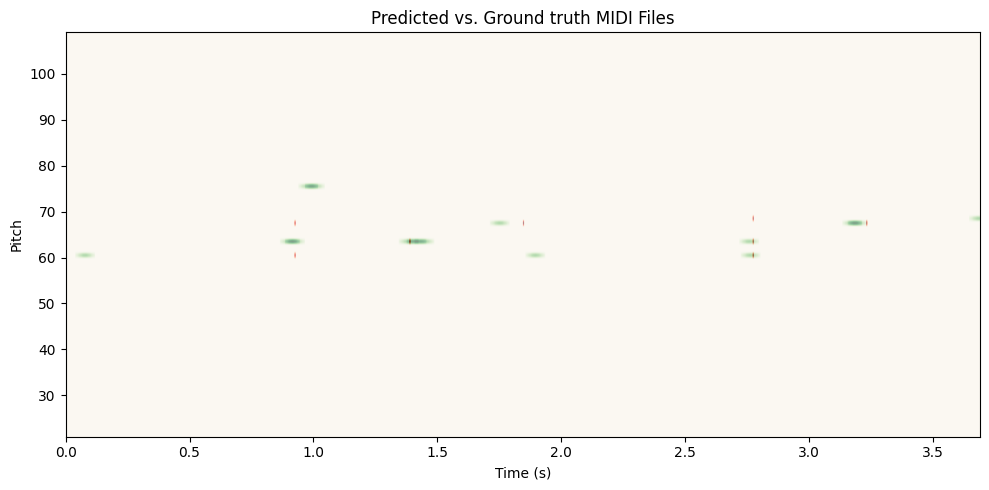

In [47]:
onset_hat, offset_hat = utils.detect_onset_offset(midi_hat, filter=True)
spec.compare_midi(offset_hat, offset, times_test, 0, 4)

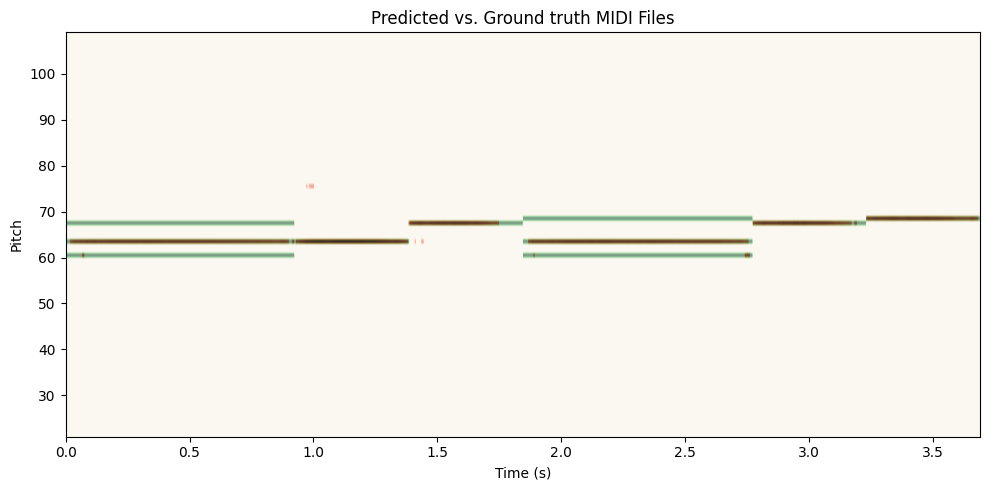

In [46]:
spec.compare_midi(midi, midi_hat, times_test, 0, 4)

In [48]:
octave_weight, note_weight, sparse_factor = 1, 10, 1e4
loss = utils.midi_loss(midi_hat, midi, active_midi, octave_weight, note_weight, sparse_factor)
# loss

tensor(3.7636) tensor(4.5453) tensor(0.7186) tensor(9.0275)


In [ ]:
audio_file = "data/take-five-loop.flac"
waveform, sample_rate = torchaudio.load(audio_file)

In [ ]:
y = y[:20000]

In [ ]:
f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr=sr)

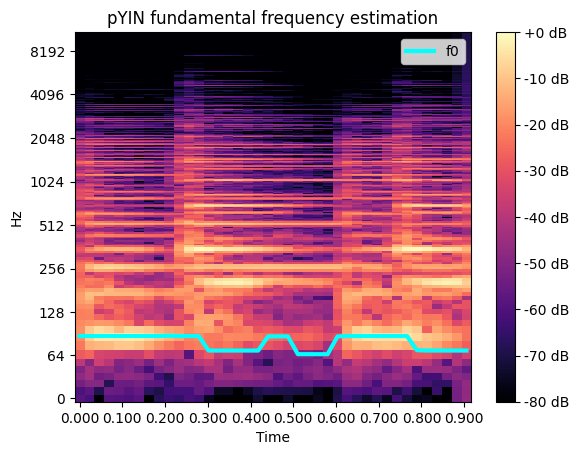

In [ ]:
import matplotlib.pyplot as plt
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')